<a href="https://colab.research.google.com/github/ny147/infant-classification/blob/nice/sample_one_class_with_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install tensorflow_io


     |████████████████████████████████| 23.4 MB 2.0 MB/s 


In [2]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 199 kB 4.6 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [3]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
path = '/content/drive/My Drive/Infant/new/'
#iris = pd.read_csv(path+"Iris.csv")

Mounted at /content/drive/


## Load Audio to Jupyter

In [65]:


def load_audio(file_path):
    waveform, sample_rate = librosa.load(file_path)
    return waveform, sample_rate

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        # speaker_id,version,gender,age,reason = speaker.split("-")
        #sp = speaker.split("-")
        #speaker_id = sp[0]
        #gender = sp[2]
        #age =sp[3]


        # Load audio
        waveform, sample_rate = load_audio(file_path)
        dataset.append([waveform, sample_rate])
        #dataset.append([waveform, sample_rate, label, speaker_id, gender,age])

    return dataset



## Prepare Data

In [ ]:
trainset_speechcommands_hungry = load_audio_files('./data/hungry', 'hungry')
trainset_speechcommands_burping = load_audio_files('./data/burping', 'burping')
trainset_speechcommands_tired = load_audio_files('./data/tired', 'tired')
trainset_speechcommands_belly_pain = load_audio_files('./data/belly_pain', 'belly_pain')
trainset_speechcommands_discomfort = load_audio_files('./data/discomfort', 'discomfort')


In [ ]:
print(f'Length of hungry dataset: {len(trainset_speechcommands_hungry)}')
print(f'Length of burping dataset: {len(trainset_speechcommands_burping)}')
print(f'Length of tired dataset: {len(trainset_speechcommands_tired)}')
print(f'Length of belly_pain dataset: {len(trainset_speechcommands_belly_pain)}')
print(f'Length of discomfort dataset: {len(trainset_speechcommands_discomfort)}')

Length of hungry dataset: 382
Length of burping dataset: 8
Length of tired dataset: 24
Length of belly_pain dataset: 16
Length of discomfort dataset: 27


In [ ]:
hungry_waveform = trainset_speechcommands_hungry[0][0]
hungry_sample_rate = trainset_speechcommands_hungry[0][1]
print(f'Yes Waveform: {hungry_waveform}')
print(f'Yes Sample Rate: {hungry_sample_rate}')
#print(f'Yes Label: {trainset_speechcommands_hungry[0][2]}')
#print(f'Yes ID: {trainset_speechcommands_hungry[0][3]}')

Yes Waveform: [ 1.2662281e-06  1.4249257e-06 -1.5742867e-08 ... -2.9080665e-02
 -2.0946175e-02 -9.9853482e-03]
Yes Sample Rate: 22050


## Waveform plot

In [66]:
timescale = np.arange(hungry_waveform .shape[0])
plt.figsize=(12, 8)
plt.plot(timescale, hungry_waveform)
plt.show()

NameError: ignored

In [67]:
import IPython.display as ipd
ipd.Audio(hungry_waveform, rate=hungry_sample_rate)

NameError: ignored

In [ ]:
print(tf.shape(hungry_waveform))

tf.Tensor([148176], shape=(1,), dtype=int32)


## Spectrogram

In [ ]:
def get_spectrogram(waveform):

    frame_length = 255
    frame_step = 128
    # Padding for files with less than 16000 samples
    # zero_padding = tf.zeros([56000] - tf.shape(waveform), dtype=tf.float32)
    zero_padding = tf.zeros([60000] - tf.shape(waveform), dtype=tf.float32)
    
    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length_waveform = tf.concat([waveform, zero_padding], 0)

    # Option 1: Use tfio to get the spectrogram
    spect = tfio.audio.spectrogram(input=equal_length_waveform, nfft=frame_length, window=frame_length, stride=frame_step)

    # Option 2: Use tf.signal processing to get the Short-time Fourier transform (stft)
    spectrogram = tf.signal.stft(equal_length_waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)

    return spectrogram, spect

In [ ]:
def get_spectrogram2(waveform,sample):
    fast_fourier_transf = np.fft.fft(waveform)
    
    magnitude = np.abs(fast_fourier_transf)
    
    frequency = np.linspace(0, sample, len(magnitude))
    
    left_mag = magnitude[:int(len(magnitude)/2)]
    left_freq = frequency[:int(len(frequency)/2)]
    
    n_fft = 128
    
    hop_length = 32    
    audio_stft = librosa.core.stft(waveform, hop_length=hop_length, n_fft=n_fft)
    
    # gathering the absolute values for all values in our audio_stft 
    spectrogram = np.abs(audio_stft)
    
    # Converting the amplitude to decibels
    log_spectro = librosa.power_to_db(spectrogram)
    
    return log_spectro

In [ ]:
#spectrogram, spect = get_spectrogram(hungry_waveform)
log_sp = get_spectrogram2(hungry_waveform,hungry_sample_rate)

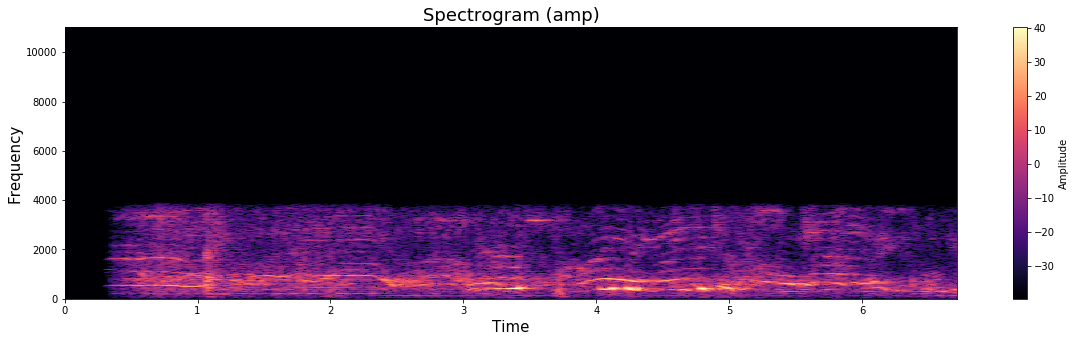

In [ ]:
plt.figure(figsize=(20, 5))
#librosa.display.specshow(log_sp,sr=hungry_sample_rate, x_axis='time',y_axis='hz',hop_length=128,cmap='magma')
librosa.display.specshow(log_sp,sr=hungry_sample_rate, x_axis='time',y_axis='log',hop_length=128,cmap='magma')
#plt.colorbar(label='Amplitude')
#plt.title('Spectrogram (amp)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.axis('off')
plt.savefig('testimg.jpg', bbox_inches="tight", pad_inches = 0)
plt.show()

In [ ]:
def create_images(dataset, label_dir,path,num):
    # make directory
    test_directory = f'./data/test_oneclass/{path}/{label_dir}/'
    train_directory = f'./data/train_oneclass/{path}/{label_dir}/'

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    os.makedirs(train_directory, mode=0o777, exist_ok=True)
    for i, data in enumerate(dataset):
        sample_rate = data[1]
        waveform = data[0]
        spectrogram = get_spectrogram2(waveform,sample_rate)
        librosa.display.specshow(spectrogram,sr=sample_rate, x_axis='time',y_axis='log',hop_length=128,cmap='magma')
        plt.axis('off')
        # Split test and train images by 30%
        if i % 3 == 0:
            plt.savefig(f'./data/test_oneclass/{path}/{label_dir}/spec_img{i}{num}.jpg', bbox_inches="tight", pad_inches = 0)
            #plt.imsave(f'./data/test_oneclass/{path}/{label_dir}/spec_img{i}{num}.jpg', spectrogram, cmap='magma')
        else:
            plt.savefig(f'./data/train_oneclass/{path}/{label_dir}/spec_img{i}{num}.jpg', bbox_inches="tight", pad_inches = 0)
            #plt.imsave(f'./data/train_oneclass/{path}/{label_dir}/spec_img{i}{num}.jpg', spectrogram, cmap='magma')


In [ ]:
create_images(trainset_speechcommands_hungry, 'hungry','hungry_one',0)
create_images(trainset_speechcommands_tired, 'non_hungry','hungry_one',1)
create_images(trainset_speechcommands_burping, 'non_hungry','hungry_one',2)
create_images(trainset_speechcommands_discomfort, 'non_hungry','hungry_one',3)
create_images(trainset_speechcommands_belly_pain, 'non_hungry','hungry_one',4)

NameError: ignored

In [ ]:
create_images(trainset_speechcommands_tired, 'non_discomfort','discomfort_one',1)
create_images(trainset_speechcommands_burping, 'non_discomfort','discomfort_one',2)
create_images(trainset_speechcommands_discomfort, 'discomfort','discomfort_one',3)
create_images(trainset_speechcommands_belly_pain, 'non_discomfort','discomfort_one',4)

In [ ]:
create_images(trainset_speechcommands_tired, 'tired','tired_one',1)
create_images(trainset_speechcommands_burping, 'non_tired','tired_one',2)
create_images(trainset_speechcommands_belly_pain, 'non_tired','tired_one',4)

In [ ]:
create_images(trainset_speechcommands_burping, 'burping','burping_one',2)
create_images(trainset_speechcommands_belly_pain, 'non_burping','burping_one',4)

### Build the model

In [30]:
train_directory = path +'/train_oneclass/hungry_one'
test_directory = path + '/test_oneclass/hungry_one'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=321,
    validation_split=None, subset=None)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256),
    validation_split=None, subset=None)

class_names = train_ds.class_names
print(class_names)

Found 303 files belonging to 2 classes.
Found 154 files belonging to 2 classes.
['hungry', 'non_hungry']


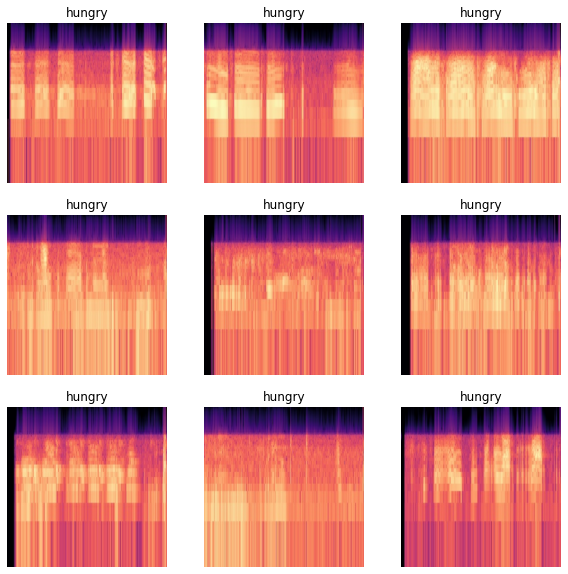

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Create Model

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [33]:
x_train=[]
y_train=[]
for images, labels in train_ds.unbatch().take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

In [34]:
x_test=[]
y_test=[]
for images, labels in test_ds.unbatch().take(-1):
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

In [35]:
# x_train.shape()

In [36]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [37]:
y_train = np.array(y_train)
y_test = np.array(y_test)

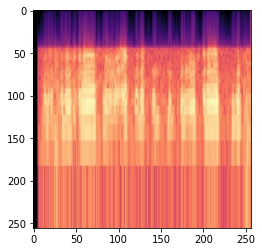

In [38]:
plt.imshow(x_train[0].astype("uint8"))

In [39]:
num_classes = 2
img_height = 256
img_width = 256

In [56]:
 def create_weight(n_sample,n_class,n_class_sample):
     weight = n_sample/(n_class*n_class_sample)
     return weight

In [41]:
# np.count_nonzero(y_train == 1 )

In [42]:
# model = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#     tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D((3,3)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D((3,3)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D((3,3)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [43]:
# learning_rate =  0.002
# loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# # loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# # optimizer = tf.keras.optimizers.SGD(learning_rate)
# #optimizer = tf.keras.optimizers.Adadelta(learning_rate)
# #optimizer = tf.keras.optimizers.Adamax(learning_rate)
# optimizer = tf.keras.optimizers.Adam(learning_rate)# modify weight in Adam
# metrics = ['accuracy']
# model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)

In [44]:
# Set the epocks
# ทำ stop + validation
# epochs = 20
# history = model.fit(x_train,y_train,epochs=epochs,
#                     validation_data=(x_val, y_val), shuffle=True)

In [57]:
class_weights = {0:0, 1:0}
class_count = np.array([254,49])
for i in range(num_classes):
    class_weights[i]=create_weight(303,num_classes,class_count[i])

In [58]:
from sklearn.model_selection import KFold

# Model configuration
learning_rate =  0.002
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# optimizer = tf.keras.optimizers.SGD(learning_rate)
#optimizer = tf.keras.optimizers.Adadelta(learning_rate)
#optimizer = tf.keras.optimizers.Adamax(learning_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate)# modify weight in Adam
epochs = 20
metrics = ['accuracy']
#numberofK-fold
num_folds = 10
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = x_train
targets = y_train

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    # Define the model architecture
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    # Compile the model
    model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)


    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],
                        epochs=epochs,class_weight = class_weights)

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)

    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


9/9 [==============================] - 17s 2s/step - loss: 0.7939 - accuracy: 0.6324
Epoch 2/20
9/9 [==============================] - 11s 1s/step - loss: 0.6928 - accuracy: 0.8382
Epoch 3/20
9/9 [==============================] - 11s 1s/step - loss: 0.6915 - accuracy: 0.8382
Epoch 4/20
9/9 [==============================] - 11s 1s/step - loss: 0.6835 - accuracy: 0.8382
Epoch 5/20
9/9 [==============================] - 11s 1s/step - loss: 0.6674 - accuracy: 0.7574
Epoch 6/20
9/9 [==============================] - 11s 1s/step - loss: 0.6494 - accuracy: 0.5882
Epoch 7/20
9/9 [==============================] - 11s 1s/step - loss: 0.6347 - accuracy: 0.5110
Epoch 8/20
9/9 [==============================] - 11s 1s/step - loss: 0.6242 - accuracy: 0.4449
Epoch 9/20
9/9 [==============================] - 11s 1s/step - loss: 0.6065 - accuracy: 0.5294
Epoch 10/20
9/9 [==============================] - 11s 1s/step - loss: 0.5936 - accuracy: 0.4301
Epoch 11/20
9/9 [==============================] -

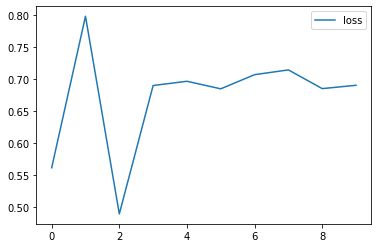

In [59]:
plt.plot(loss_per_fold,label = 'loss')
#plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

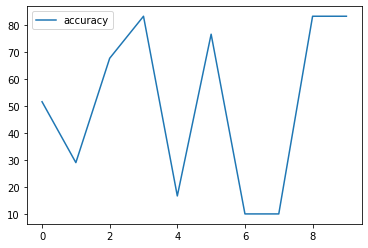

In [60]:
plt.plot(acc_per_fold,label = 'accuracy')
#plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.legend()
plt.show()

In [61]:
def binary_transform(pred):
    if pred > 0.5:
        predicted = 1
    else:
        predicted = 0
    return predicted 

In [62]:
pred = model.predict(x_test)

vfunc = np.vectorize(binary_transform)
y_pred = vfunc(y_pred)
actual = x_test

print(f'Number correct: {correct} out of {sum_size}')
print(f'Accuracy {correct / sum_size}')

Number correct: 128 out of 154
Accuracy 0.8311688311688312


In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=["Hungry","Non_hungry"]))

              precision    recall  f1-score   support

      Hungry       0.83      1.00      0.91       128
  Non_hungry       0.00      0.00      0.00        26

    accuracy                           0.83       154
   macro avg       0.42      0.50      0.45       154
weighted avg       0.69      0.83      0.75       154



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<function matplotlib.pyplot.show>

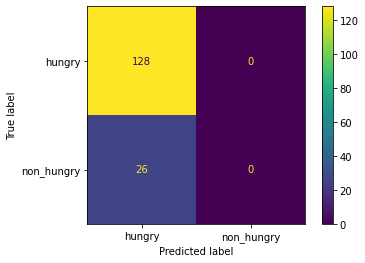

In [64]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show